In [44]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [45]:
df=pd.read_csv("../../data/merged/len3_prod_DN.csv",encoding="shift-jis",index_col=0)
# df["prod_date"]

Estimation

In [46]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [47]:
# change to the datetime format
# df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 217 entries, (114, 2009) to (799, 2021)
Columns: 108 entries, efficacy to year_trend
dtypes: float64(17), int32(3), int64(82), object(6)
memory usage: 182.4+ KB


(108, 13, 18)

In [48]:
# months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [49]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m10          0.2410     0.1937     1.2441     0.2153     -0.1416      0.6236
elapsed_m9           0.2300     0.1965     1.1703     0.2436     -0.1581      0.6180
elapsed_m8          -0.0136     0.2160    -0.0628     0.9500     -0.4401      0.4130
elapsed_m7          -0.0535     0.2267    -0.2361     0.8136     -0.5011      0.3941
elapsed_m6           0.2096     0.1374     1.5249     0.1293     -0.0619      0.4810
elapsed_m5           0.3662     0.0860     4.2608     0.0000      0.1965      0.5360
elapsed_m4           0.2560     0.1530     1.6730     0.0963     -0.0462      0.5583
elapsed_m3           0.3415     0.1799     1.8989     0.0594     -0.0137      0.6968
elapsed_m2           0.4220     0.3625     1.1641     0.2461     

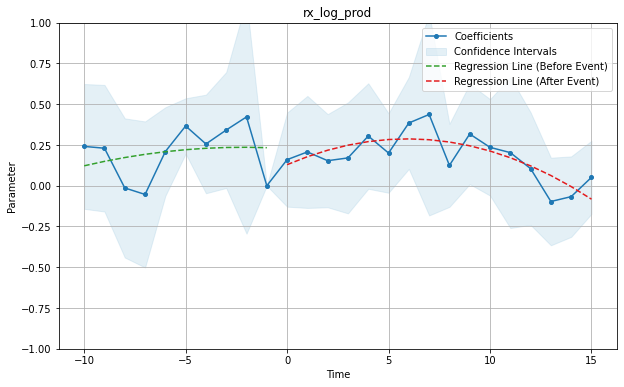

In [50]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend

# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_prod",title="rx_log_prod",ylim=(-1,1),period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m10          -0.0525     0.2762    -0.1902     0.8494     -0.5981      0.4930
elapsed_m9            0.5596     0.3378     1.6564     0.0996     -0.1076      1.2268
elapsed_m8            0.2520     0.3629     0.6943     0.4885     -0.4648      0.9687
elapsed_m7            0.2525     0.4408     0.5728     0.5676     -0.6181      1.1231
elapsed_m6            0.2597     0.3362     0.7727     0.4409     -0.4042      0.9237
elapsed_m5           -0.0486     0.2510    -0.1935     0.8468     -0.5443      0.4471
elapsed_m4            0.0432     0.2604     0.1657     0.8686     -0.4712      0.5576
elapsed_m3           -0.1459     0.2974    -0.4906     0.6244     -0.7334      0.4415
elapsed_m2            0.2429     0.2716     0.8941    

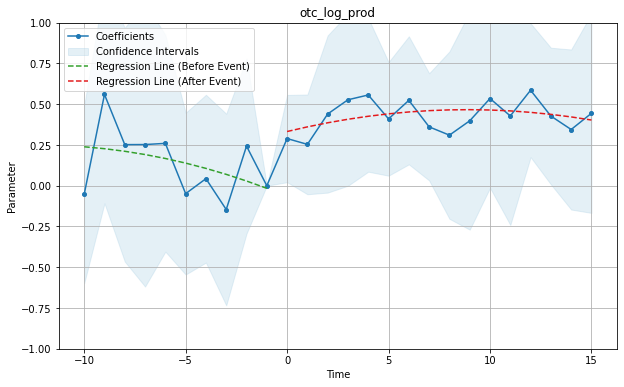

In [51]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_otc_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_prod",title="otc_log_prod",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)